This notebook includes the code to load the Fashion-MNIST dataset using Keras, and a skeleton for the main sections that should be included in the notebook. Please see the assignment specification for more detail. You may wish to add extra subsections where appropriate. 

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [2]:
!pip install scikeras


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from scikeras.wrappers import KerasClassifier

import sys
import sklearn
import time
from sklearn import model_selection, metrics 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, KFold
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

# Ensure stability across runs
np.random.seed(42)
tf.random.set_seed(42)
keras.backend.clear_session()

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


## 1. Data loading, preprocessing, and exploration
We have included the code to load the dataset below. Please proceed with your data exploration and preprocessing steps, including creating any relevant data subsets required. The documentation for the data loading function can be accessed [here](https://keras.io/api/datasets/fashion_mnist/).

## 1.1. Data loading

In [1]:
# Load the Fashion-MNIST dataset training and test sets as numpy arrays
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
assert X_train_full.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train_full.shape == (60000,)
assert y_test.shape == (10000,)

In [ ]:
# An ordered list of the class names
class_names = ["T-shirt/top",
               "Trouser",
               "Pullover",
               "Dress",
               "Coat",
               "Sandal",
               "Shirt",
               "Sneaker",
               "Bag",
               "Ankle boot"
              ]

## 1.2. Data Exploration

Firslt, we can examine the shape of the data arrays


In [8]:
print(f"Shape of X_train_full: {X_train_full.shape}")
print(f"Shape of y_train_full: {y_train_full.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train_full: (60000, 28, 28)
Shape of y_train_full: (60000,)
Shape of X_test: (10000, 28, 28)
Shape of y_test: (10000,)


We found that the data type in the training set is represented as a byte (uint8), which can take values from 0 to 255.

In [9]:
X_train_full.dtype

dtype('uint8')

## 1.3. Data  preprocessing and ploting
Divide the pixel values by 255 to scale the input features to a 0-1 range. (which prevent large inputs causing gradients very close to 0 after passing the neuron output through an activation function)

In [10]:
# Scale the data to the range 0-1
X_train_full  = X_train_full / 255.
X_test = X_test / 255.

The first numpy array [28,28] can be plot:

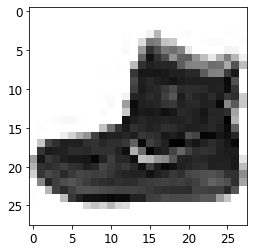

In [11]:
plt.imshow(X_train_full[0], cmap="binary")
plt.show()

If we check the further information on the dataset doucumentation, we found that boot should be classified as label 9. To prove that:

In [12]:
print(np.unique(y_train_full))
print("The first image lable is: ",y_train_full[0])

[0 1 2 3 4 5 6 7 8 9]
The first image lable is:  9


We can use a function in the tutoril slides to plot more samples：

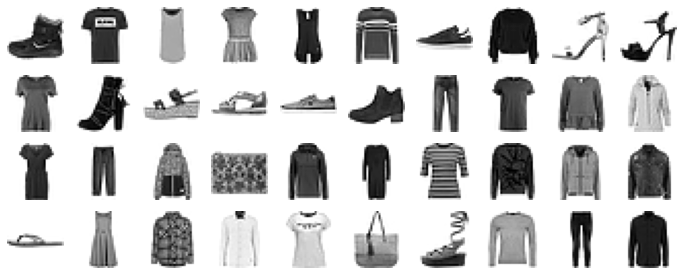

In [13]:
def plot_image(image):
  plt.imshow(image, cmap="gray", interpolation="nearest")
  plt.axis("off")


def plot_color_image(image):
  plt.imshow(image, interpolation="nearest")
  plt.axis("off")

def plot_examples(data, n_rows=4, n_cols=10):
    """Plot a grid of MNIST examples of a specified size."""
    
    # Size figure depending on the size of the grid
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    
    for row in range(n_rows):
        for col in range(n_cols):
            
            # Get next index of image
            index = n_cols * row + col
            
            # Plot the image at appropriate place in grid
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index], cmap="binary")
            plt.axis('off')
            
    plt.show()

plot_examples(X_train_full)

In [14]:
# Check the format of the label by looking at the first five examples
print(y_train_full[0:5])

[9 0 0 3 0]


## 2. Algorithm design and setup

### 2.1 Algorithm of choice from first six weeks of course (SVM)

#### 2.1.1 Prepare the data

In [15]:
def pic_to_list(train_list):
  x_list = []
  for x in train_list:
    for ele in x:
      x_list.append(ele)
  return x_list
print(type(X_train_full))
X_SVM = np.zeros(shape=(60000,784))
i = 0
for x in X_train_full:
  X_SVM[i] = pic_to_list(x)
  i = i + 1


<class 'numpy.ndarray'>


In [16]:
pca = PCA(n_components=200).fit(X_SVM)
X_train_pca = pca.transform(X_SVM)

#### 2.1.2 Setting the 10 fold stratified cross-validation

In [17]:
cvKFold=StratifiedKFold(n_splits=4, shuffle=True, random_state=0)

#### 2.1.3 Hyperparameter tuning (Grid Search)

In [19]:
C = [0.001, 0.01, 0.1, 1, 10, 100] 
gamma = [0.001, 0.01, 0.1, 1, 10, 100] 

def bestLinClassifier(X,y):
    param_grid = {'C': C, 'gamma': gamma}
    clf = GridSearchCV(SVC(kernel="linear"), param_grid, cv=4, return_train_score=True)
    clf.fit(X,y)

    result = {}
    result['C'] = clf.best_params_.get('C')
    result['gamma'] = clf.best_params_.get('gamma')

    return result

In [20]:
LinClassresult = bestLinClassifier(X_train_pca[:1000,:], y_train_full[:1000])
print(LinClassresult)


{'C': 0.1, 'gamma': 0.001}


The best parameter combination is C=0.1 and gamma=0.001.

#### 2.1.3 Final SVM

In [ ]:
Final_SVM = SVC(C=0.1,gamma=0.001,kernel="linear")
Final_SVM.fit(X_train_pca[:60000,:], y_train_full[:60000])
X_test_SVM = np.zeros(shape=(10000,784))
i = 0
for x in X_test:
  X_test_SVM[i] = pic_to_list(x)
  i = i + 1
X_test_pca = pca.transform(X_test_SVM)
y_pred = Final_SVM.predict(X_test_pca)



In [ ]:
# Output the accuracy on test data
accuracy_score(y_test, y_pred)

0.857

The final accuracy is 0.857.

### 2.2 Fully connected neural network

#### 2.2.1 Creating a validation set

In [21]:
# Aside 10% of the original training data for validation set which helps to  
# hyperparameter tuning and determine the appropriate point to stop training to minimise overfitting 
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.9)

#### 2.2.2 Defining the model

In [ ]:
# Define our MLP layer by layer
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),       # first flatten layer tansfer data shape [28,28] to vector with 748 dimensions. 
    keras.layers.Dense(300, activation="tanh"),       # fully connected layer called Dense
    keras.layers.Dense(100, activation="tanh"),
    keras.layers.Dense(10, activation="softmax")      # Output layer that has 10 neurans.
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


#### 2.2.3 Specifying the optimiser and loss function

In [ ]:
opt = keras.optimizers.SGD(learning_rate=5e-2)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

#### 2.2.4 Training and evaluating the model

In [ ]:
# Train the classifier.
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

In [ ]:
# Convert the history dictionary to a Pandas dataframe and extract the accuracies
accuracies = pd.DataFrame(history.history)[['accuracy', 'val_accuracy']]

# Plot the accuracies
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.8, 1)
plt.xlabel('Epoch')
plt.show()

We now compare the validation accuracy with the test accuracy:

In [ ]:
# Evaluate the classifier on the test data.
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy on test data: {accuracy:.4f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.3389 - accuracy: 0.8805
Accuracy on test data: 0.8805


Validation accuracy at the end of 20 epoch is 0.8882, while the accuracy on the test set is 0.8805.

#### 2.2.5 Hyperparameter tuning

In [ ]:
def build_mlp(
    n_hidden_layers=2, n_hidden_neurons=50,
    activation_function="relu", input_shape=[28,28]
):
    """Build a Keras MLP for 10 class classification with desired parameters."""
    
    model = keras.models.Sequential()
    
    # Add the input layer
    model.add(keras.layers.Flatten(input_shape=input_shape))
    
    # Add the hidden layers with desired size and activation function
    for layer in range(n_hidden_layers):
        model.add(keras.layers.Dense(n_hidden_neurons, activation=activation_function))
        
    # Add the output layer for 10 class classification
    model.add(keras.layers.Dense(10, activation="softmax"))
    
    return model

In [ ]:
# Create a KerasClassifier object which works with sklearn grid searches
# We need to pass default values of arguments in build_mlp if we wish to tune them
keras_classifier = KerasClassifier(build_mlp,
                  n_hidden_layers=2,
                  n_hidden_neurons=50,
                  activation_function="relu",
                  loss="sparse_categorical_crossentropy",
                  optimizer="sgd",
                  optimizer__lr=0.01,
                  metrics=["accuracy"]
                )

In [ ]:
param_grid = {
    "optimizer__lr": [0.1, 0.01, 0.001],
    "activation_function": ["relu", "sigmoid", "tanh", None]
      }

grid_search_cv = GridSearchCV(keras_classifier, param_grid, cv=3, verbose=2)
grid_search_cv.fit(X_train, y_train, epochs=20)

Create a function to conver dict to string:

In [38]:
def dict_to_string_list(dic):
  # This function helps to produce appropriate 
  # visualisations/tables of the trends in hyperparameter search
  
  string_list = []
  for x in dic:
    s = str(x["activation_function"])+"\n"+str(x["optimizer__lr"])  
    string_list.append(s)
  
  return string_list

In [ ]:
print(grid_search_cv.best_params_)
best_model = grid_search_cv.best_estimator_.model

para = grid_search_cv.cv_results_["params"]       #params combinations

plt.figure(figsize=(12, 3))               #change figure size
plt.gca().set_ylim(50, 90)
plt.bar(dict_to_string_list(para),grid_search_cv.cv_results_["mean_fit_time"])  # here we use params conbinations as x-axis and time as y-axis


NameError: ignored

<BarContainer object of 12 artists>

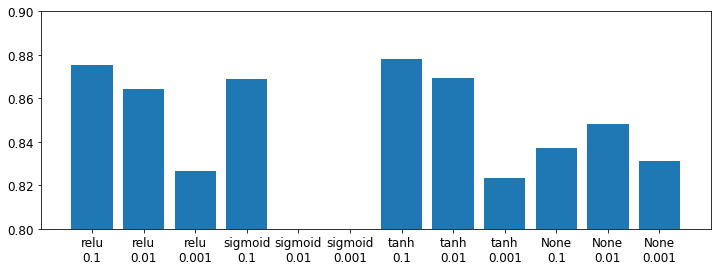

In [ ]:
plt.figure(figsize=(12, 4)) 
plt.gca().set_ylim(0.8, 0.9)
plt.bar(dict_to_string_list(para),grid_search_cv.cv_results_["mean_test_score"])

#### 2.2.6 Final MLP model

Epoch 1/20
1688/1688 [==============================] - 11s 5ms/step - loss: 0.5329 - accuracy: 0.8069 - val_loss: 0.4244 - val_accuracy: 0.8530
Epoch 2/20
1688/1688 [==============================] - 7s 4ms/step - loss: 0.3848 - accuracy: 0.8589 - val_loss: 0.4718 - val_accuracy: 0.8282
Epoch 3/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3446 - accuracy: 0.8706 - val_loss: 0.3627 - val_accuracy: 0.8665
Epoch 4/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3199 - accuracy: 0.8818 - val_loss: 0.3533 - val_accuracy: 0.8733
Epoch 5/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3022 - accuracy: 0.8856 - val_loss: 0.3521 - val_accuracy: 0.8710
Epoch 6/20
1688/1688 [==============================] - 8s 5ms/step - loss: 0.2866 - accuracy: 0.8932 - val_loss: 0.4227 - val_accuracy: 0.8493
Epoch 7/20
1688/1688 [==============================] - 10s 6ms/step - loss: 0.2736 - accuracy: 0.8971 - val_loss: 0.3327 - val_accurac

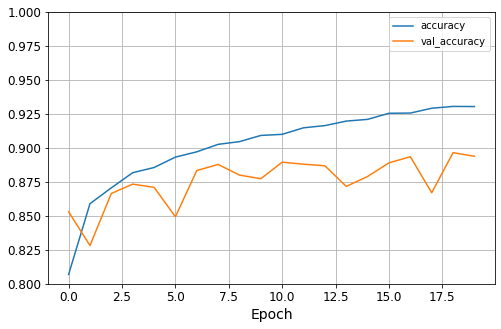

In [ ]:
model_final = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),       
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")     
])
opt_final = keras.optimizers.SGD(learning_rate=0.1)
model_final.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt_final,
              metrics=['accuracy'])
history = model_final.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
accuracies = pd.DataFrame(history.history)[['accuracy', 'val_accuracy']]

# Plot the accuracies
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.8, 1)
plt.xlabel('Epoch')
plt.show()

In [ ]:
# Evaluate the classifier on the test data.
loss, accuracy = model_final.evaluate(X_test, y_test)
print(f"Fianl model Accuracy on test data: {accuracy:.4f}")

## 2.3 Convolutional neural network

#### 2.3.1 Adding an extra dimension

In [22]:
# Add an extra dimension to our data
X_train = np.expand_dims(X_train, -1)
X_valid = np.expand_dims(X_valid, -1)
X_test = np.expand_dims(X_test, -1)
print(f"New shape of X_train: {X_train.shape}")

New shape of X_train: (54000, 28, 28, 1)


#### 2.3.2 Defining the model

In [23]:
model = keras.Sequential([
    
# Specify the input shape
keras.Input(shape=(28, 28, 1)),
    
# Conv and pool block 1
keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
# Conv and pool block 2
keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
# Flatten and classify using dense output layer
keras.layers.Flatten(),
keras.layers.Dropout(0.5),
keras.layers.Dense(10, activation="softmax"),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

#### 2.3.3 Specifying the optimiser and loss function

In [24]:
# Compile model with loss, optimiser, and metrics
model.compile(loss='sparse_categorical_crossentropy',
optimizer="adam",
metrics=['accuracy'])

#### 2.3.4 Training and evaluating the model

In [26]:
# Train the model for 10 epochs with batch size 128
batch_size = 128
epochs = 10
history = model.fit(X_train, y_train, batch_size=batch_size,
epochs=epochs, validation_data=(X_valid, y_valid))



Epoch 1/10
422/422 [==============================] - 2s 6ms/step - loss: 0.6890 - accuracy: 0.7503 - val_loss: 0.4595 - val_accuracy: 0.8408
Epoch 2/10
422/422 [==============================] - 2s 5ms/step - loss: 0.4574 - accuracy: 0.8334 - val_loss: 0.3941 - val_accuracy: 0.8640
Epoch 3/10
422/422 [==============================] - 2s 5ms/step - loss: 0.4048 - accuracy: 0.8552 - val_loss: 0.3591 - val_accuracy: 0.8722
Epoch 4/10
422/422 [==============================] - 2s 5ms/step - loss: 0.3726 - accuracy: 0.8654 - val_loss: 0.3399 - val_accuracy: 0.8783
Epoch 5/10
422/422 [==============================] - 2s 5ms/step - loss: 0.3504 - accuracy: 0.8743 - val_loss: 0.3250 - val_accuracy: 0.8852
Epoch 6/10
422/422 [==============================] - 2s 5ms/step - loss: 0.3340 - accuracy: 0.8790 - val_loss: 0.3040 - val_accuracy: 0.8913
Epoch 7/10
422/422 [==============================] - 2s 5ms/step - loss: 0.3195 - accuracy: 0.8837 - val_loss: 0.3007 - val_accuracy: 0.8942
Epoch 

In [27]:
# Evaluate the classifier on the test data.
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy on test data: {accuracy:.4f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.2877 - accuracy: 0.8967
Accuracy on test data: 0.8967


#### 2.3.5 Hyperparameter tuning

In [28]:
def build_cnn(kernel_size=(3,3), strides=1, activation_function="relu", input_shape=[28,28,1]):

    """Build a Keras CNN for 10 class classification with desired parameters."""
    
    model = keras.models.Sequential()
    
    # Add the input layer
    model.add(keras.Input(shape=input_shape))
    
    # Add the convolution layers with desired size and activation function
    model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        
    # Add the output layer for 10 class classification
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(10, activation="softmax"))
    
    return model

In [29]:
# Create a KerasClassifier object which works with sklearn grid searches
# We need to pass default values of arguments in build_mlp if we wish to tune them
keras_classifier = KerasClassifier(build_cnn,
          kernel_size=(3,3),
          strides=1,
          activation_function="relu",
          loss="sparse_categorical_crossentropy",
          optimizer="adam",
          optimizer__lr=0.01,
          metrics=["accuracy"]
          )

In [36]:
param_grid = {
  "optimizer__lr": [0.1, 0.01, 0.001],
  "kernel_size": [(3,3), (5,5)],
  "strides": [1, 2]
}
grid_search_cv = GridSearchCV(keras_classifier, param_grid, cv=3, verbose=2)
grid_search_cv.fit(X_train, y_train, epochs=20)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 1.1176 - accuracy: 0.6108
Epoch 2/20
1125/1125 [==============================] - 4s 4ms/step - loss: 0.9997 - accuracy: 0.6338
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.0878 - accuracy: 0.6019
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.1214 - accuracy: 0.5936
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.1273 - accuracy: 0.5859
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.0971 - accuracy: 0.5928
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.1196 - accuracy: 0.5874
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.1138 - accuracy: 0.5904
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.2305 - accuracy: 0.5500
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.2859 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 2.5093 - accuracy: 0.0991
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3141 - accuracy: 0.0996
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3165 - accuracy: 0.0986
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3160 - accuracy: 0.0989
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3155 - accuracy: 0.0995
Epoch 6/20
1125/1125 [==============================] - 4s 3ms/step - loss: 2.3155 - accuracy: 0.0980
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3148 - accuracy: 0.1012
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3154 - accuracy: 0.1022
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3158 - accuracy: 0.0968
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3156 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 2.4842 - accuracy: 0.0990
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3153 - accuracy: 0.1007
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3159 - accuracy: 0.0982
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3159 - accuracy: 0.0988
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3149 - accuracy: 0.1015
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3146 - accuracy: 0.0990
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3153 - accuracy: 0.0996
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3153 - accuracy: 0.0978
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3157 - accuracy: 0.0996
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3158 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 1.0948 - accuracy: 0.6134
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.0480 - accuracy: 0.6125
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.0895 - accuracy: 0.6023
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.1612 - accuracy: 0.5743
Epoch 5/20
1125/1125 [==============================] - 4s 4ms/step - loss: 1.1638 - accuracy: 0.5743
Epoch 6/20
1125/1125 [==============================] - 4s 4ms/step - loss: 1.1365 - accuracy: 0.5826
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.2013 - accuracy: 0.5602
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.1265 - accuracy: 0.5876
Epoch 9/20
1125/1125 [==============================] - 5s 5ms/step - loss: 1.1775 - accuracy: 0.5721
Epoch 10/20
1125/1125 [==============================] - 5s 4ms/step - loss: 1.1587 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 2.4371 - accuracy: 0.0990
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3141 - accuracy: 0.0995
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3165 - accuracy: 0.0985
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3160 - accuracy: 0.0989
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3155 - accuracy: 0.0995
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3155 - accuracy: 0.0980
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3148 - accuracy: 0.1012
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3154 - accuracy: 0.1022
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3158 - accuracy: 0.0968
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3156 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 2.4818 - accuracy: 0.0985
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3152 - accuracy: 0.1006
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3159 - accuracy: 0.0981
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3159 - accuracy: 0.0988
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3149 - accuracy: 0.1015
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3146 - accuracy: 0.0990
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3153 - accuracy: 0.0996
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3153 - accuracy: 0.0978
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3157 - accuracy: 0.0996
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3158 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 0.5715 - accuracy: 0.7956
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4636 - accuracy: 0.8314
Epoch 3/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.4530 - accuracy: 0.8322
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4387 - accuracy: 0.8381
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4424 - accuracy: 0.8381
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4267 - accuracy: 0.8406
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4245 - accuracy: 0.8430
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4244 - accuracy: 0.8397
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4327 - accuracy: 0.8378
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4256 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 0.5665 - accuracy: 0.7964
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4623 - accuracy: 0.8330
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4456 - accuracy: 0.8388
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4344 - accuracy: 0.8407
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4319 - accuracy: 0.8420
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4291 - accuracy: 0.8452
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4230 - accuracy: 0.8464
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4231 - accuracy: 0.8462
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4193 - accuracy: 0.8464
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4192 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 0.5572 - accuracy: 0.7981
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4680 - accuracy: 0.8313
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4525 - accuracy: 0.8356
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4439 - accuracy: 0.8388
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4338 - accuracy: 0.8400
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4205 - accuracy: 0.8444
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4254 - accuracy: 0.8442
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4183 - accuracy: 0.8461
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4295 - accuracy: 0.8422
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4208 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 0.5584 - accuracy: 0.7964
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4630 - accuracy: 0.8305
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4562 - accuracy: 0.8329
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4350 - accuracy: 0.8391
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4330 - accuracy: 0.8414
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4231 - accuracy: 0.8433
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4233 - accuracy: 0.8430
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4220 - accuracy: 0.8432
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4178 - accuracy: 0.8438
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4230 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 0.5642 - accuracy: 0.7993
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4659 - accuracy: 0.8317
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4521 - accuracy: 0.8356
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4398 - accuracy: 0.8403
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4407 - accuracy: 0.8399
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4375 - accuracy: 0.8410
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4307 - accuracy: 0.8423
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4311 - accuracy: 0.8428
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4304 - accuracy: 0.8442
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4258 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 0.5649 - accuracy: 0.7954
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4632 - accuracy: 0.8303
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4504 - accuracy: 0.8347
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4453 - accuracy: 0.8389
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4337 - accuracy: 0.8402
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4283 - accuracy: 0.8439
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4316 - accuracy: 0.8422
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4255 - accuracy: 0.8438
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4247 - accuracy: 0.8430
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4176 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 0.6245 - accuracy: 0.7699
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4320 - accuracy: 0.8428
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3885 - accuracy: 0.8596
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3579 - accuracy: 0.8695
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3358 - accuracy: 0.8763
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3197 - accuracy: 0.8834
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3069 - accuracy: 0.8889
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2940 - accuracy: 0.8924
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2851 - accuracy: 0.8945
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2791 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 4ms/step - loss: 0.6184 - accuracy: 0.7724
Epoch 2/20
1125/1125 [==============================] - 5s 5ms/step - loss: 0.4293 - accuracy: 0.8445
Epoch 3/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.3871 - accuracy: 0.8617
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3562 - accuracy: 0.8715
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3380 - accuracy: 0.8780
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3174 - accuracy: 0.8843
Epoch 7/20
1125/1125 [==============================] - 4s 4ms/step - loss: 0.3069 - accuracy: 0.8870
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2943 - accuracy: 0.8928
Epoch 9/20
1125/1125 [==============================] - 4s 4ms/step - loss: 0.2883 - accuracy: 0.8950
Epoch 10/20
1125/1125 [==============================] - 4s 4ms/step - loss: 0.2807 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 0.6157 - accuracy: 0.7784
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4323 - accuracy: 0.8443
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3856 - accuracy: 0.8603
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3543 - accuracy: 0.8730
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3350 - accuracy: 0.8773
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3167 - accuracy: 0.8849
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3033 - accuracy: 0.8896
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2956 - accuracy: 0.8907
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2869 - accuracy: 0.8962
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2820 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 0.6292 - accuracy: 0.7668
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4291 - accuracy: 0.8424
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3779 - accuracy: 0.8618
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3514 - accuracy: 0.8734
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3294 - accuracy: 0.8776
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3143 - accuracy: 0.8856
Epoch 7/20
1125/1125 [==============================] - 4s 4ms/step - loss: 0.2987 - accuracy: 0.8893
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2921 - accuracy: 0.8920
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2813 - accuracy: 0.8964
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2764 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 0.6184 - accuracy: 0.7755
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4375 - accuracy: 0.8427
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3925 - accuracy: 0.8590
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3645 - accuracy: 0.8700
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3428 - accuracy: 0.8756
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3246 - accuracy: 0.8831
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3100 - accuracy: 0.8869
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2973 - accuracy: 0.8908
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2901 - accuracy: 0.8944
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2831 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 0.6233 - accuracy: 0.7728
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4332 - accuracy: 0.8435
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3850 - accuracy: 0.8610
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3568 - accuracy: 0.8714
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3341 - accuracy: 0.8802
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3182 - accuracy: 0.8842
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3038 - accuracy: 0.8903
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2942 - accuracy: 0.8921
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2866 - accuracy: 0.8944
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2785 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 2.4226 - accuracy: 0.0983
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3144 - accuracy: 0.1022
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3155 - accuracy: 0.1000
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3166 - accuracy: 0.0979
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3156 - accuracy: 0.1002
Epoch 6/20
1125/1125 [==============================] - 4s 3ms/step - loss: 2.3156 - accuracy: 0.0980
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3146 - accuracy: 0.1002
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3151 - accuracy: 0.0981
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3170 - accuracy: 0.0981
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3153 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 2.4778 - accuracy: 0.0986
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3205 - accuracy: 0.0992
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3165 - accuracy: 0.0989
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3160 - accuracy: 0.0989
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3155 - accuracy: 0.0995
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3155 - accuracy: 0.0981
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3148 - accuracy: 0.1012
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3154 - accuracy: 0.1022
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3158 - accuracy: 0.0968
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3156 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 1.5377 - accuracy: 0.5101
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.2631 - accuracy: 0.5243
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.2621 - accuracy: 0.5246
Epoch 4/20
1125/1125 [==============================] - 4s 3ms/step - loss: 1.2849 - accuracy: 0.5148
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.3152 - accuracy: 0.5042
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.3048 - accuracy: 0.5073
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.2796 - accuracy: 0.5132
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.3249 - accuracy: 0.5025
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.2871 - accuracy: 0.5131
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.2654 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 1.3561 - accuracy: 0.5092
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.2529 - accuracy: 0.5320
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.2438 - accuracy: 0.5410
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.2414 - accuracy: 0.5394
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.2262 - accuracy: 0.1416
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3159 - accuracy: 0.0980
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3147 - accuracy: 0.1002
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3151 - accuracy: 0.0978
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3170 - accuracy: 0.0980
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3153 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 1.4594 - accuracy: 0.5232
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.2929 - accuracy: 0.5297
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.2883 - accuracy: 0.5350
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.3763 - accuracy: 0.5062
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3161 - accuracy: 0.0997
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3157 - accuracy: 0.0979
Epoch 7/20
1125/1125 [==============================] - 4s 3ms/step - loss: 2.3149 - accuracy: 0.1012
Epoch 8/20
1125/1125 [==============================] - 4s 3ms/step - loss: 2.3154 - accuracy: 0.1023
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3158 - accuracy: 0.0968
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3156 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 2.5252 - accuracy: 0.0996
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3153 - accuracy: 0.1006
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3159 - accuracy: 0.0982
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3159 - accuracy: 0.0988
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3149 - accuracy: 0.1015
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3146 - accuracy: 0.0990
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3153 - accuracy: 0.0996
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3153 - accuracy: 0.0978
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3157 - accuracy: 0.0996
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.3158 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 0.5869 - accuracy: 0.7844
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4833 - accuracy: 0.8255
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4651 - accuracy: 0.8307
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4542 - accuracy: 0.8332
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4448 - accuracy: 0.8377
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4416 - accuracy: 0.8396
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4361 - accuracy: 0.8400
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4281 - accuracy: 0.8429
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4406 - accuracy: 0.8386
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4262 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 0.5665 - accuracy: 0.7956
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4581 - accuracy: 0.8330
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4446 - accuracy: 0.8391
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4302 - accuracy: 0.8439
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4238 - accuracy: 0.8456
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4217 - accuracy: 0.8463
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4191 - accuracy: 0.8461
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4153 - accuracy: 0.8497
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4206 - accuracy: 0.8472
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4161 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 0.5742 - accuracy: 0.7922
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4713 - accuracy: 0.8296
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4549 - accuracy: 0.8340
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4466 - accuracy: 0.8377
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4338 - accuracy: 0.8424
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4324 - accuracy: 0.8408
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4294 - accuracy: 0.8416
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4263 - accuracy: 0.8449
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4266 - accuracy: 0.8431
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4251 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 0.5598 - accuracy: 0.7961
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4626 - accuracy: 0.8302
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4487 - accuracy: 0.8355
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4432 - accuracy: 0.8369
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4363 - accuracy: 0.8368
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4318 - accuracy: 0.8407
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4219 - accuracy: 0.8419
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4214 - accuracy: 0.8441
Epoch 9/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.4205 - accuracy: 0.8441
Epoch 10/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.4164 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 0.5649 - accuracy: 0.7961
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4640 - accuracy: 0.8316
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4451 - accuracy: 0.8371
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4416 - accuracy: 0.8389
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4432 - accuracy: 0.8372
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4315 - accuracy: 0.8419
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4295 - accuracy: 0.8425
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4319 - accuracy: 0.8413
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4313 - accuracy: 0.8441
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4273 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 0.5719 - accuracy: 0.7900
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4741 - accuracy: 0.8267
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4561 - accuracy: 0.8347
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4484 - accuracy: 0.8354
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4397 - accuracy: 0.8389
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4345 - accuracy: 0.8413
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4300 - accuracy: 0.8406
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4274 - accuracy: 0.8411
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4255 - accuracy: 0.8456
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4333 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 0.6230 - accuracy: 0.7692
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4309 - accuracy: 0.8441
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3818 - accuracy: 0.8625
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3583 - accuracy: 0.8712
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3356 - accuracy: 0.8790
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3213 - accuracy: 0.8827
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3065 - accuracy: 0.8894
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2969 - accuracy: 0.8901
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2854 - accuracy: 0.8944
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2796 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 0.6227 - accuracy: 0.7724
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4227 - accuracy: 0.8479
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3793 - accuracy: 0.8652
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3538 - accuracy: 0.8724
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3310 - accuracy: 0.8803
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3131 - accuracy: 0.8864
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3008 - accuracy: 0.8905
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2864 - accuracy: 0.8969
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2840 - accuracy: 0.8971
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2736 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 0.6252 - accuracy: 0.7730
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4372 - accuracy: 0.8410
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3902 - accuracy: 0.8605
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3581 - accuracy: 0.8705
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3387 - accuracy: 0.8769
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3194 - accuracy: 0.8835
Epoch 7/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.3066 - accuracy: 0.8893
Epoch 8/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.2938 - accuracy: 0.8943
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2894 - accuracy: 0.8944
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2800 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 0.6134 - accuracy: 0.7738
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4200 - accuracy: 0.8473
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3761 - accuracy: 0.8626
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3503 - accuracy: 0.8724
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3247 - accuracy: 0.8824
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3131 - accuracy: 0.8858
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2995 - accuracy: 0.8895
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2897 - accuracy: 0.8939
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2804 - accuracy: 0.8960
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2728 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 0.6297 - accuracy: 0.7692
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4335 - accuracy: 0.8449
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3903 - accuracy: 0.8589
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3620 - accuracy: 0.8695
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3389 - accuracy: 0.8778
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3187 - accuracy: 0.8849
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3069 - accuracy: 0.8879
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2968 - accuracy: 0.8918
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2913 - accuracy: 0.8925
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2823 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1125/1125 [==============================] - 4s 3ms/step - loss: 0.6113 - accuracy: 0.7776
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4204 - accuracy: 0.8482
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3781 - accuracy: 0.8654
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3490 - accuracy: 0.8758
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3267 - accuracy: 0.8825
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3108 - accuracy: 0.8883
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2988 - accuracy: 0.8916
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2920 - accuracy: 0.8942
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2841 - accuracy: 0.8971
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2729 - accurac

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1688/1688 [==============================] - 6s 3ms/step - loss: 0.5626 - accuracy: 0.7934
Epoch 2/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.3935 - accuracy: 0.8579
Epoch 3/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.3519 - accuracy: 0.8733
Epoch 4/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.3266 - accuracy: 0.8819
Epoch 5/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.3079 - accuracy: 0.8869
Epoch 6/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.2962 - accuracy: 0.8916
Epoch 7/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.2866 - accuracy: 0.8966
Epoch 8/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.2782 - accuracy: 0.8984
Epoch 9/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.2702 - accuracy: 0.9012
Epoch 10/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.2641 - accurac

GridSearchCV(cv=3,
             estimator=KerasClassifier(activation_function='relu', kernel_size=(3, 3), loss='sparse_categorical_crossentropy', metrics=['accuracy'], model=<function build_cnn at 0x7f4530278050>, optimizer='adam', optimizer__lr=0.01, strides=1),
             param_grid={'kernel_size': [(3, 3), (5, 5)],
                         'optimizer__lr': [0.1, 0.01, 0.001],
                         'strides': [1, 2]},
             verbose=2)

In [ ]:
print(grid_search_cv.best_params_)

{'kernel_size': (5, 5), 'optimizer__lr': 0.001, 'strides': 1}


The best hyperparameter combination for our CNN model is kernel size = (5,5), learning rate = 0.001 and strides = 1.

KeyError: ignored

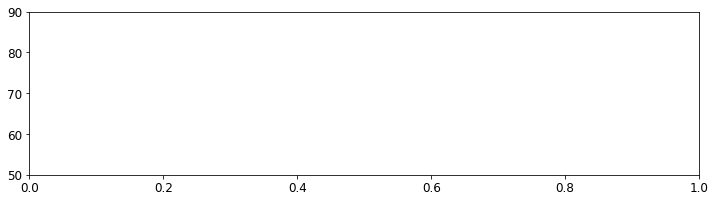

In [39]:
#best_model = grid_search_cv.best_estimator_.model

para = grid_search_cv.cv_results_["params"]       #params combinations

plt.figure(figsize=(12, 3))               #change figure size
plt.gca().set_ylim(50, 90)
plt.bar(dict_to_string_list(para),grid_search_cv.cv_results_["mean_fit_time"])  # here we use params conbinations as x-axis and time as y-axis

In [ ]:
plt.figure(figsize=(12, 4)) 
plt.gca().set_ylim(0.8, 0.9)
plt.bar(dict_to_string_list(para),grid_search_cv.cv_results_["mean_test_score"])

#### 2.3.6 Final CNN model

Epoch 1/20
1688/1688 [==============================] - 7s 4ms/step - loss: 0.3136 - accuracy: 0.8852 - val_loss: 0.2816 - val_accuracy: 0.8990
Epoch 2/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.2951 - accuracy: 0.8909 - val_loss: 0.2676 - val_accuracy: 0.9002
Epoch 3/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.2829 - accuracy: 0.8962 - val_loss: 0.2633 - val_accuracy: 0.9055
Epoch 4/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.2767 - accuracy: 0.8982 - val_loss: 0.2870 - val_accuracy: 0.8923
Epoch 5/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.2651 - accuracy: 0.9024 - val_loss: 0.2632 - val_accuracy: 0.9030
Epoch 6/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.2654 - accuracy: 0.9014 - val_loss: 0.2574 - val_accuracy: 0.9032
Epoch 7/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.2574 - accuracy: 0.9049 - val_loss: 0.2509 - val_accuracy:

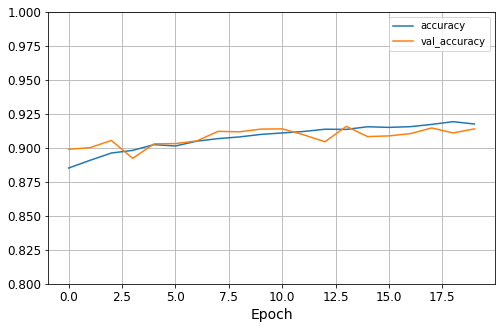

In [35]:
cnn_model_final = keras.models.Sequential([
          # Specify the input shape
          keras.Input(shape=(28, 28, 1)),
              
          # Conv and pool block 1
          keras.layers.Conv2D(32, strides=1, kernel_size=(5, 5), activation="relu"),
          keras.layers.MaxPooling2D(pool_size=(2, 2)),
              
          # Conv and pool block 2
          keras.layers.Conv2D(64, strides=1, kernel_size=(5, 5), activation="relu"),
          keras.layers.MaxPooling2D(pool_size=(2, 2)),
              
          # Flatten and classify using dense output layer
          keras.layers.Flatten(),
          keras.layers.Dropout(0.5),
          keras.layers.Dense(10, activation="softmax"),   
])


cnn_model_final.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))




accuracies = pd.DataFrame(history.history)[['accuracy', 'val_accuracy']]

# Plot the accuracies
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.8, 1)
plt.xlabel('Epoch')
plt.show()

In [ ]:
# Evaluate our final model on the test data.
loss, accuracy = cnn_model_final.evaluate(X_test, y_test)
print(f"Fianl CNN model Accuracy on test data: {accuracy:.4f}")

The accuracy of our final CNN model is 0.91